<a href="https://colab.research.google.com/github/samyumobi/Text-recognition-in-vehicle-images/blob/main/vehicle_license_plate_detection_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](attachment:image.png)

This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Preparation of the data

Import libraries

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We display the files in Kaggle repertoire :

In [5]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [6]:
# ! pip install kaggle


In [7]:
# # from google.colab import files
# # files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d andrewmvd/car-plate-detection
# # ! mkdir train

# # ! unzip train.zip -d train



We create the variable X containing all the images of cars by resizing them.



In [8]:
IMAGE_SIZE = 224

In [9]:
import os,glob
img_dir = "/content/drive/MyDrive/archive (1).zip (Unzipped Files)/images/" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [10]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [11]:
path = '/content/drive/MyDrive/archive (1).zip (Unzipped Files)/annotations'
text_files = ['/content/drive/MyDrive/archive (1).zip (Unzipped Files)/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
resizeannotation("/content/drive/MyDrive/archive (1).zip (Unzipped Files)/annotations/Cars147.xml")

[188, 141, 101, 104]

In [14]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [15]:
import numpy as np

np.array(X).shape

(428, 224, 224, 3)

In [16]:
np.array(y).shape

(428, 4)

And we display the first eighteen image of the dataset : 

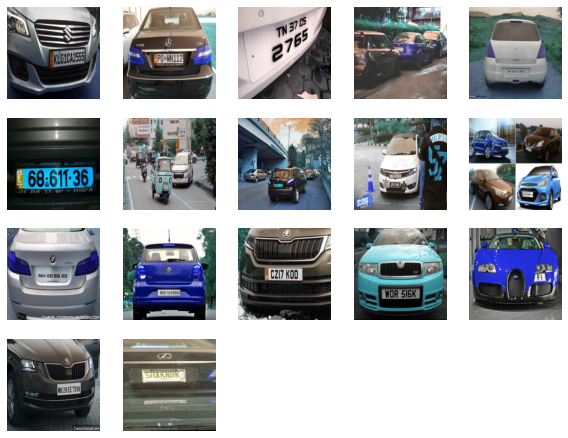

In [17]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

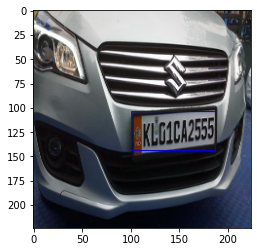

In [18]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


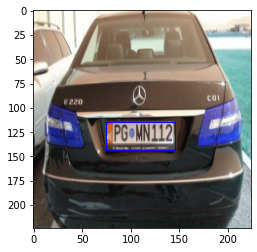

In [19]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [20]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [21]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [23]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [24]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
Non-trainable params: 14,714,688
____________________________________

In [25]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=5, verbose=1)

Epoch 1/15


In [ ]:
model.save('my_model.h5', overwrite=True) 

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [ ]:
plot_scores(train)

## DETECTION 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


In [ ]:
 y_cnn = model.predict(X_test)

We can see how our model localize license plates on our testing set :

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)



In [ ]:
%tensorboard --logdir logs/gradient_tape


#  Deploy the model

In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

## Examine saved model

In [ ]:
saved_model_cli show --dir {export_path} --all

## Serve the model

In [ ]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

In [ ]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

tail server.log

In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

In [ ]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))